# Monte Carlo Simulation Runs for Different Estimators for Triangulation

In [1]:
%load_ext autoreload
%autoreload 2
import pickle
import torch
import pandas as pd
from pathlib import Path

## Load the datasets

In [2]:
dataset = Path("../datasets/preprocessed/novtel_preprocessed.pkl")
ground_truth = Path("../datasets/ground_truth/novtel_static_ground_truth.csv")

with open(dataset, "rb") as f:
    data = pickle.load(f)
    
ground_truth = pd.read_csv(ground_truth)

In [3]:
# Check if the data are aligned 
assert len(data["z"]) == len(ground_truth)

In [4]:
import numpy as np
# Define the hyperparameters
DIM_Z = len(data["z"][0])
NUM_SV = len(data["sv_pos"][0])
DIM_X = 8
DT = 1
T = len(data["z"])
DPI = 600

measurements = data["z"].double()
satellite_positions = data["sv_pos"].double()

# Set manual seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

### Define the Noise Parameters

In [5]:
# Define the noise levels to test and apply for measurements 
MEAN = torch.ones(DIM_Z)
VAR = 25
I = torch.eye(DIM_Z).double()
COVAR = VAR * I

### Define the Models

In [6]:
from ntraingulation.dynamics_model import TransitionModel, ObservationModel, BiasedObservationModel
from  ntraingulation.dynamics_model.constant_velocity_triangulation_model import Q as Q_transformation

# Define the models
transistion_model = TransitionModel(
    dt =DT,
    learnable=False,
)
observation_model = BiasedObservationModel(
    dim_measurement=DIM_Z,
    trainable=True,
)

# Define the noise matrices for the models
Q_AUT = torch.eye(DIM_X) * 1
Q = Q_transformation(dt=DT, Q_0=Q_AUT).double()
R = torch.eye(DIM_Z).double() * 100

# Define the initial state
x0 = data["x0"].double()
P0 = data["P0"].double()

In [7]:
# Functional Models for UKF from filter py
import numpy as np
F = transistion_model.F.numpy().astype(np.float64)

def f(x: np.ndarray, dt: float) -> np.ndarray:
    return F @ x

def h(x: np.ndarray, sv_pos: np.ndarray) -> np.ndarray:
    """Returns the measurement matrix for the constant velocity model.

    Args:
        x (np.ndarray): State vector. (8,)
        sv_pos (np.ndarray): Satellite position. (n, 3)

    Returns:
        np.ndarray: Measurement matrix.
    """
    pos = x[[0, 2, 4]]
    return np.linalg.norm(pos - sv_pos, axis=1) + x[6]

## Run the Monte Carlo Simulation for the Different Estimators

### Run the Monte Carlo Simulation for Extended Kalman Filter

In [8]:
from ntraingulation.monte_carlo_runs import run_monte_carlo_sim, aekf_estimator, wsl_estimator, ekf_estimator, ukf_estimator

truncation = -1
n_mc = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float64

# Run the Monte Carlo simulation for the EKF
ekf_enu_erros = run_monte_carlo_sim(
    z_true=measurements[:truncation],
    n_mc =n_mc,
    true_position=ground_truth[["x", "y", "z"]][:truncation],
    mu_noise=MEAN,
    P_noise=COVAR,
    estimator=ekf_estimator,
    x0=x0,
    P0=P0,
    Q=Q,
    R=R,
    sv_seq=satellite_positions[:truncation],
    device="cpu",
    dtype=dtype,
    transistion_model=transistion_model,
    measurement_model=observation_model,
    is_sim=False,
    reduce=False,
)

Monte Carlo Simulation: 100%|██████████| 1/1 [00:08<00:00,  8.67s/it]


### Run Monte Carlo Simulation for Unscented Kalman Filter

In [9]:
ukf_monter_carlo_runs = run_monte_carlo_sim(
    z_true=measurements[:truncation],
    n_mc =n_mc,
    true_position=ground_truth[["x", "y", "z"]][:truncation],
    mu_noise=MEAN,
    P_noise=COVAR,
    estimator=ukf_estimator,
    dt=DT,
    x0=x0,
    P0=P0,
    Q=Q,
    R=R,
    sv_seq=satellite_positions[:truncation],
    transistion_function=f,
    measurement_function=h,
    is_sim=False,
    reduce=False,
)

Monte Carlo Simulation: 100%|██████████| 1/1 [00:03<00:00,  3.90s/it]


### Run Monte Carlo Simulation for Adaptive Extended Kalman Filter

In [10]:
aekf_enu_erros = run_monte_carlo_sim(
    z_true=measurements[:truncation],
    n_mc =n_mc,
    true_position=ground_truth[["x", "y", "z"]][:truncation],
    mu_noise=MEAN,
    P_noise=COVAR,
    estimator=aekf_estimator,
    x0=x0,
    P0=P0,
    Q=Q,
    R=R,
    sv_seq=satellite_positions[:truncation],
    device="cpu",
    dtype=dtype,
    transistion_model=transistion_model,
    measurement_model=observation_model,
    is_sim=False,
    reduce=False,
)

Monte Carlo Simulation: 100%|██████████| 1/1 [00:11<00:00, 11.87s/it]


### Run Monte Carlo Simulation for Adaptive Weighted Least Squares

In [11]:
wls_enu_errors = run_monte_carlo_sim(
    z_true=measurements[:truncation],
    n_mc =n_mc,
    true_position=ground_truth[["x", "y", "z"]][:truncation],
    mu_noise=MEAN,
    P_noise=COVAR,
    estimator=wsl_estimator,
    sv_seq=satellite_positions[:truncation],
    reduce=False,
)

Monte Carlo Simulation: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


In [12]:
import typing as tp
import seaborn as sns
import matplotlib.pyplot as plt
def plot_enu_boxen_plot_by_different_algorithm(
    alg_error_map: tp.Dict[str, pd.DataFrame],
    figsize: tp.Tuple[int, int] = (8, 5),
    title: str = "ENU Position Errors by Algorithm",
    ylabel: str = "Error [m]",
) -> None:
    """Plot the ENU position errors of the different algorithms.

    Args:

        save_path: Path to save the boxen plot.

    Returns:
        None
    """
    colnames = ["East", "North", "Up"]
    for alg in alg_error_map.keys():
        alg_error_map[alg].columns = colnames
        alg_error_map[alg] = alg_error_map[alg].abs()
        alg_error_map[alg] = alg_error_map[alg].melt(
            var_name="Direction", value_name="Error"
        )
        alg_error_map[alg]["Algorithm"] = alg

    # Concatenate the dataframes
    enus = pd.concat(alg_error_map.values(), ignore_index=True)
    # Get the boxen plot
    fig, ax = plt.subplots(figsize=figsize, dpi=300)
    sns.barplot(x="Direction", y="Error", hue="Algorithm", data=enus, ax=ax)

    # Add plot characteristics
    plt.title(title)
    plt.ylabel(ylabel=ylabel)
    plt.xlabel("Direction")
    plt.legend(title="Algorithm")
    plt.tight_layout()
    
    return fig, ax


In [13]:
def plot_enu_boxen_plot_by_different_algorithm_with_var(
    alg_error_map: tp.Dict[str, pd.DataFrame],
    figsize: tp.Tuple[int, int] = (8, 5),
    title: str = "ENU Position Errors by Algorithm",
    ylabel: str = "Error [m]",
) -> None:
    """Plot the ENU position errors of the different algorithms.

    Args:

        save_path: Path to save the boxen plot.

    Returns:
        None
    """
    colnames = ["East", "North", "Up"]
    for alg in alg_error_map.keys():
        alg_error_map[alg].columns = colnames
        alg_error_map[alg] = alg_error_map[alg].abs()
        alg_error_map[alg] = alg_error_map[alg].melt(
            var_name="Direction", value_name="Error"
        )
        alg_error_map[alg]["Algorithm"] = alg

    # Concatenate the dataframes
    enus = pd.concat(alg_error_map.values(), ignore_index=True)
    # Get the boxen plot
    fig, ax = plt.subplots(figsize=figsize, dpi=300)
    sns.boxenplot(x="Direction", y="Error", hue="Algorithm", data=enus, ax=ax)

    # Add plot characteristics
    plt.title(title)
    plt.ylabel(ylabel=ylabel)
    plt.xlabel("Direction")
    plt.legend(title="Algorithm")
    plt.tight_layout()
    
    return fig, ax



def restult_to_mean(result_by_algorithm: tp.Dict[str, pd.DataFrame]) -> tp.Dict[str, pd.DataFrame]:
    return {key: value.abs().mean(axis=0).to_frame().T for key, value in result_by_algorithm.items()}



In [14]:
result_by_algorithm = {
    "UKF": ukf_monter_carlo_runs,
    "EKF": ekf_enu_erros,
    "AEKF": aekf_enu_erros,
    "WLS" : wls_enu_errors  
    
}

In [15]:
result_by_algorithm_mean = restult_to_mean(result_by_algorithm)

(<Figure size 2400x1500 with 1 Axes>,
 <Axes: title={'center': 'ENU Position Errors by Algorithm'}, xlabel='Direction', ylabel='Error [m]'>)

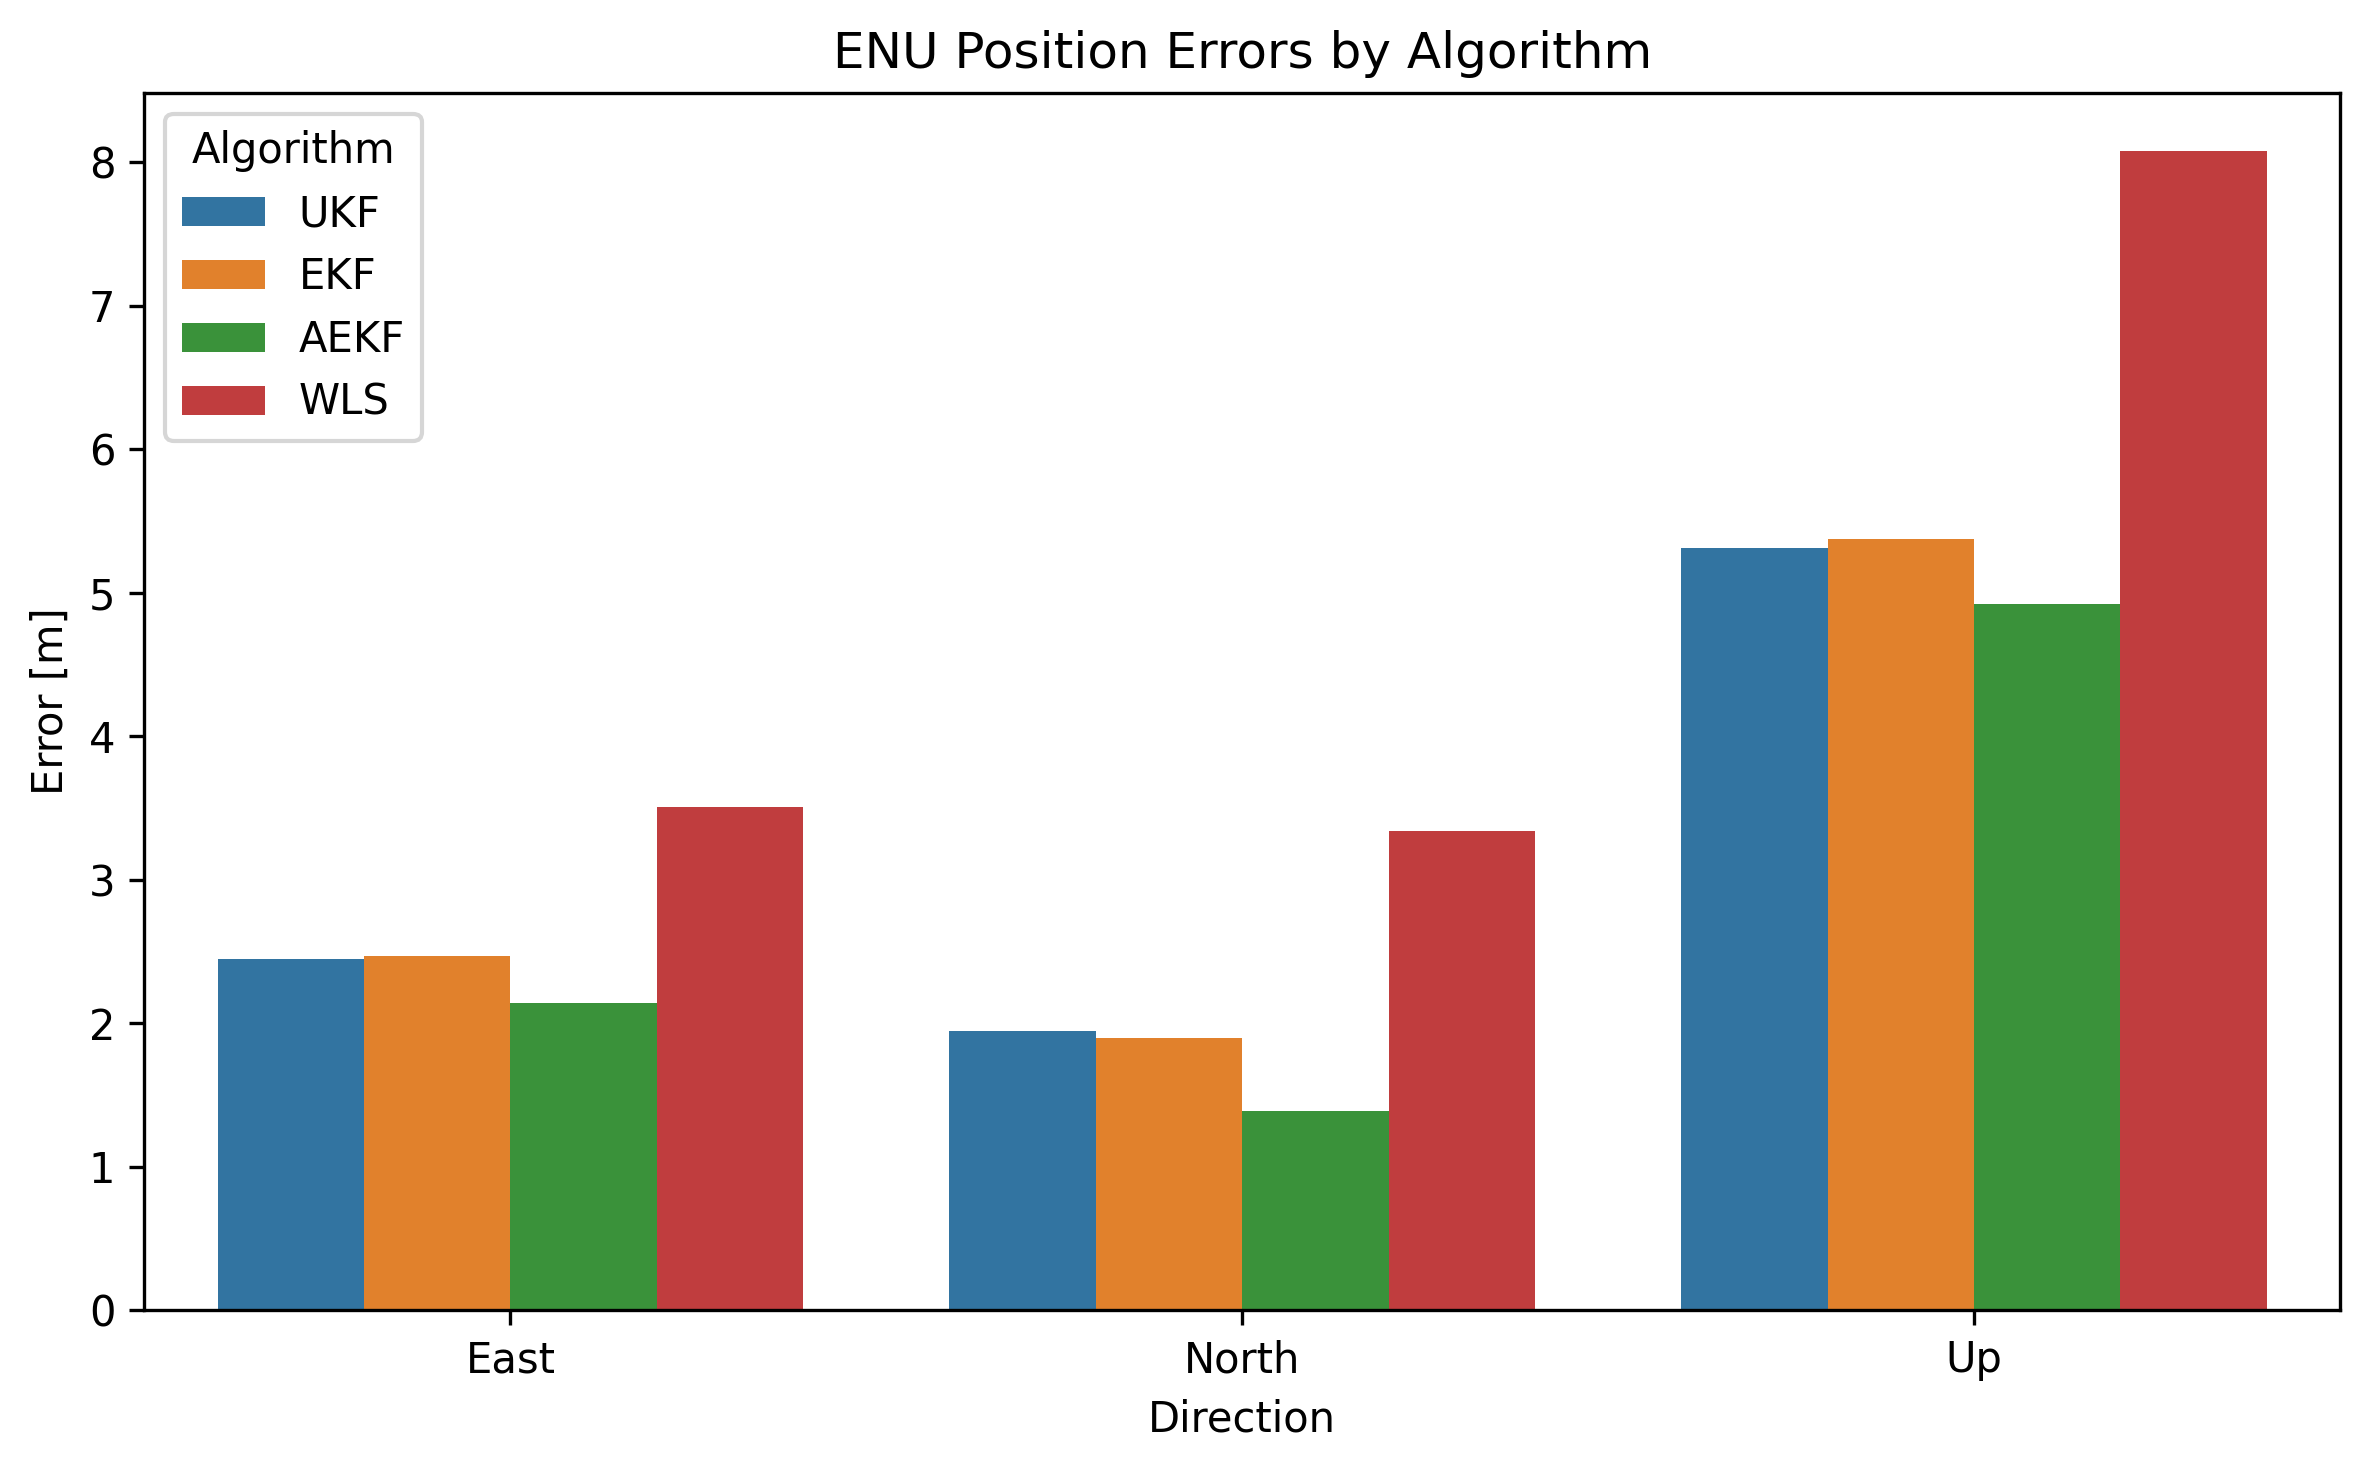

In [16]:
plot_enu_boxen_plot_by_different_algorithm(result_by_algorithm_mean)

(<Figure size 2400x1500 with 1 Axes>,
 <Axes: title={'center': 'ENU Position Errors by Algorithm'}, xlabel='Direction', ylabel='Error [m]'>)

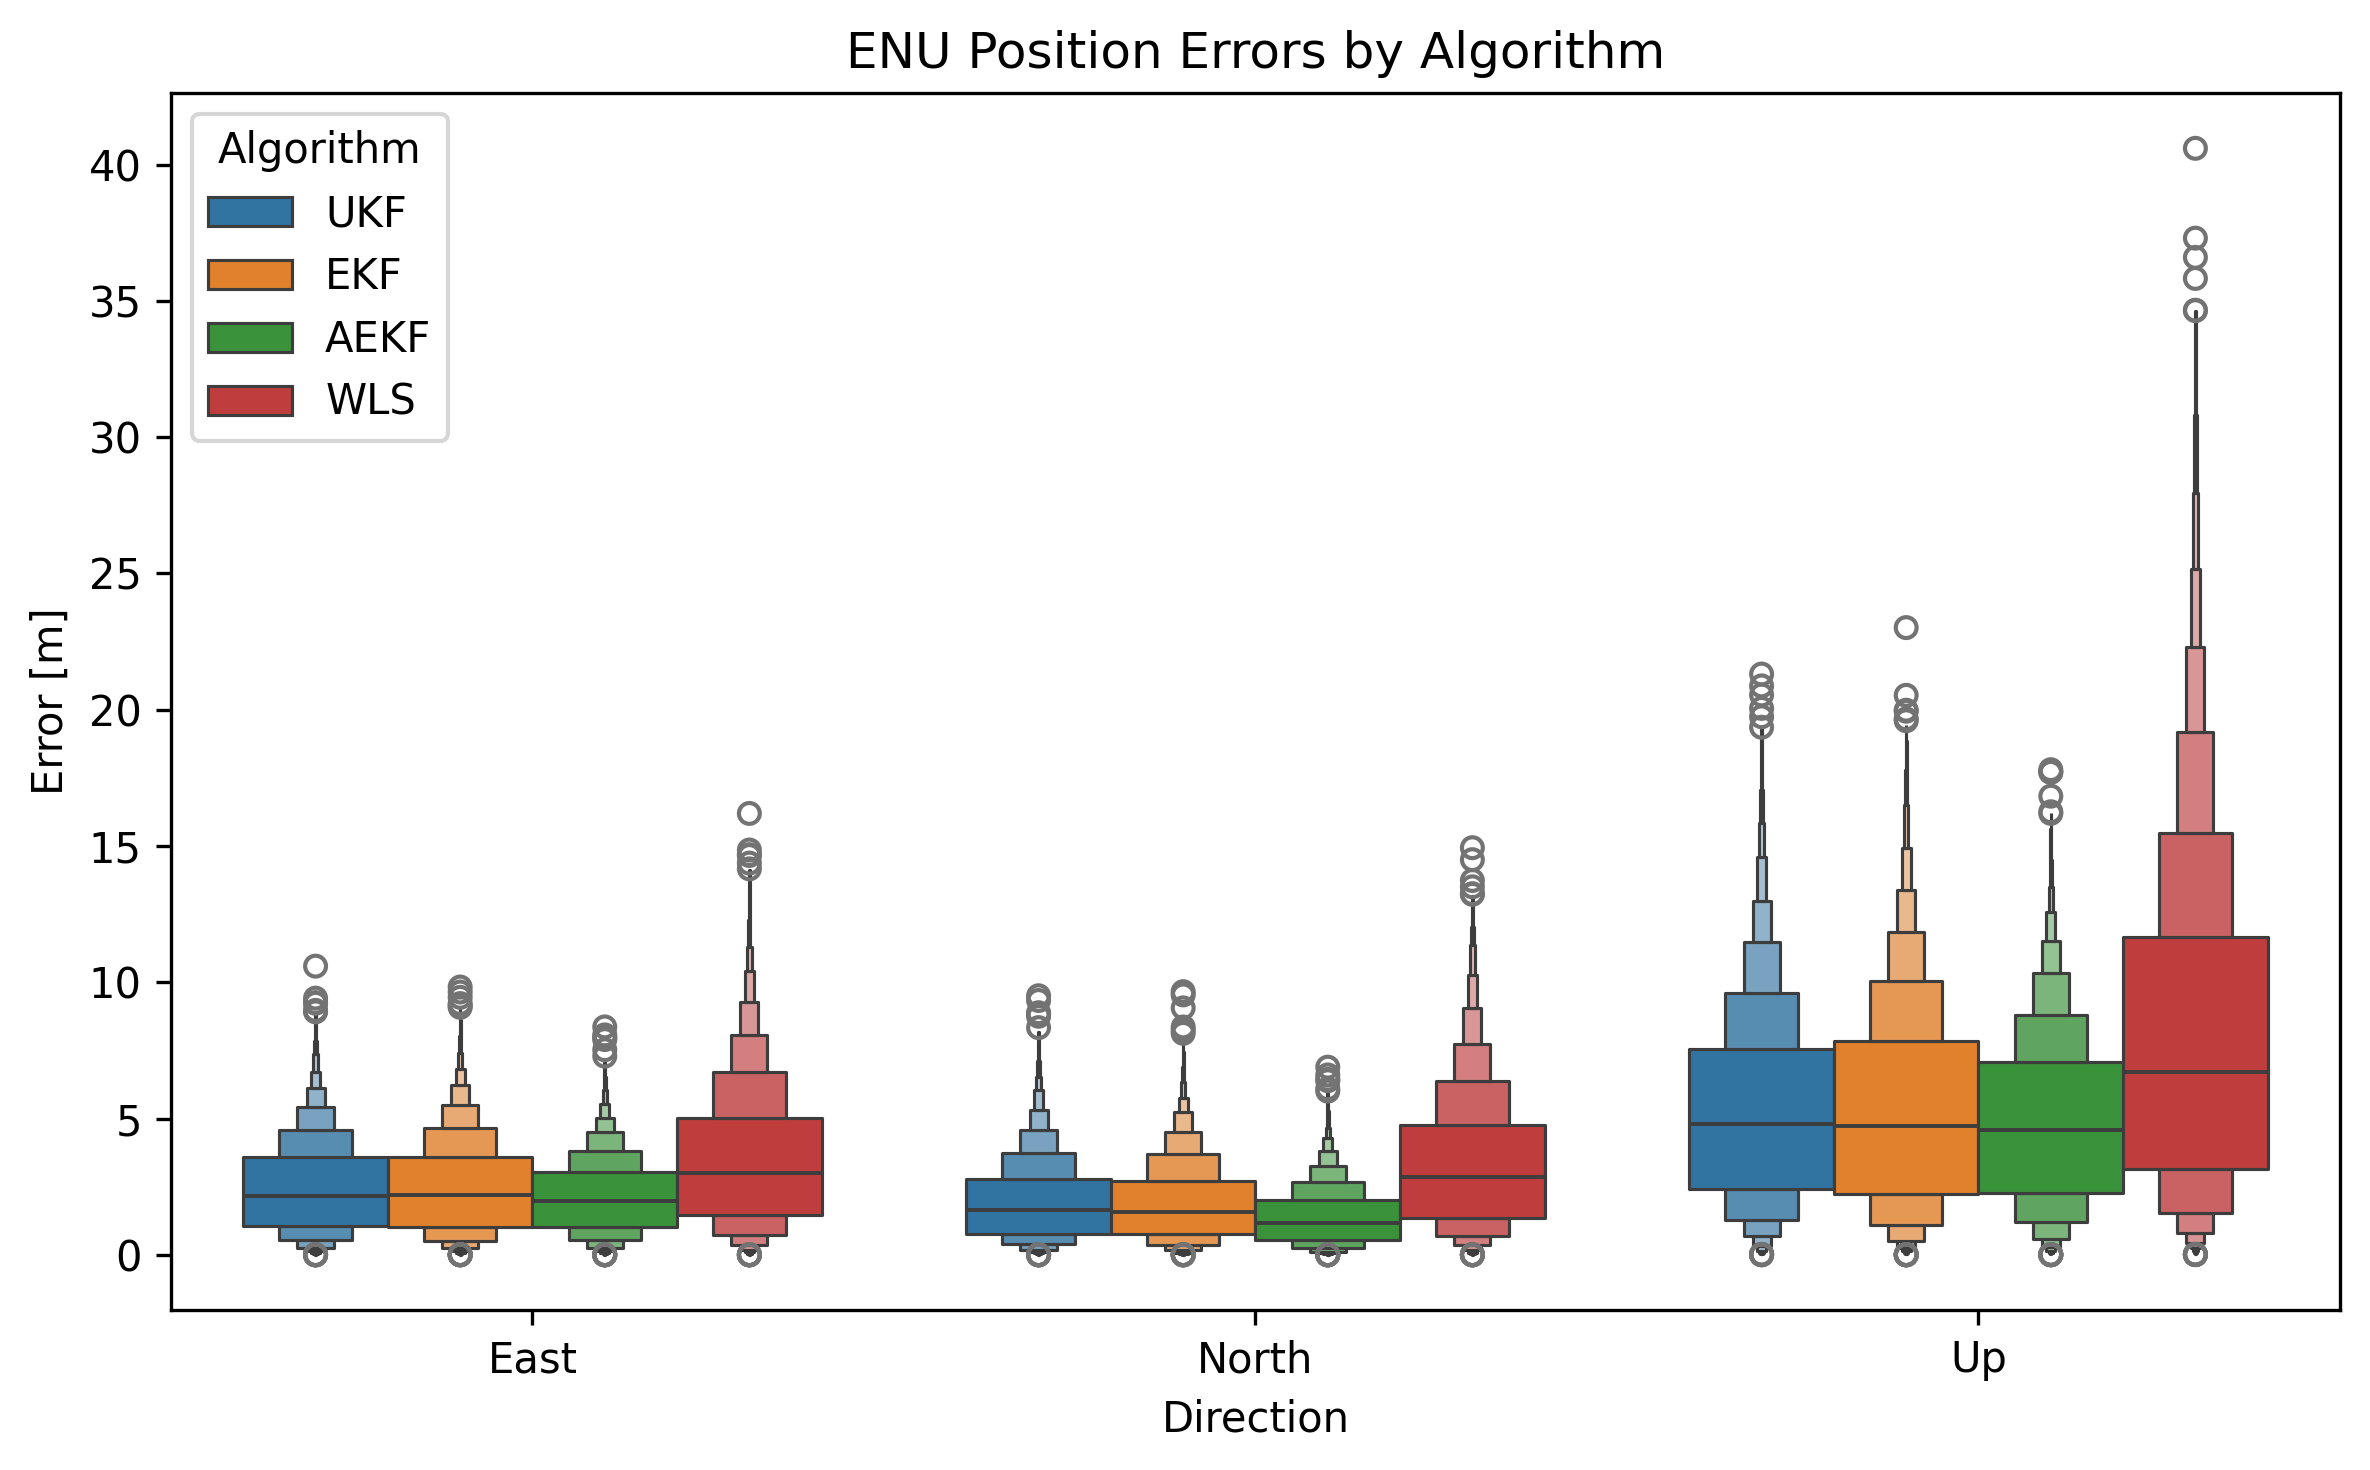

In [17]:
plot_enu_boxen_plot_by_different_algorithm_with_var(result_by_algorithm)

### Train the Diffrentiable Kalman Filter 

Let's first generate a noisy measurement dataset for the triangulation problem

In [18]:
from ntraingulation.monte_carlo_runs.run_monte_carlo_sim import apply_gaussian_noise

z_noisy = measurements


In [19]:
from diffkalman.utils import  SymmetricPositiveDefiniteMatrix, DiagonalSymmetricPositiveDefiniteMatrix
from torch.optim import  AdamW
from torch.optim.lr_scheduler import ExponentialLR
from diffkalman import  DiffrentiableKalmanFilter


NUM_CYCLES = 10
NUM_EPOCH = 10

dkf = DiffrentiableKalmanFilter(
    dim_x=DIM_X,
    dim_z=DIM_Z,
    f=transistion_model,
    h=observation_model,
).to(device=device, dtype=dtype)

Q_module = SymmetricPositiveDefiniteMatrix(M=Q, trainable=True).to(device=device, dtype=dtype)
R_module = DiagonalSymmetricPositiveDefiniteMatrix(M=R, trainable=True).to(device=device, dtype=dtype)



params = [
    {"params": Q_module.parameters(), "lr": 1e-2},
    {"params": R_module.parameters(), "lr": 0.5},
    {"params": observation_model.parameters(), "lr": 1e-2},
]

optimizer = AdamW(params, lr=1e-3)
lr_scheduler = ExponentialLR(optimizer, gamma=0.95)


### Run the Monte Carlo EM loop

In [20]:
from diffkalman.em_loop import  em_updates

train_truncation = 500
log_likelihoods = em_updates(
    dkf=dkf,
    z_seq=z_noisy[:train_truncation].to(device=device, dtype=dtype),
    x0=x0.to(device=device, dtype=dtype),
    P0=P0.to(device=device, dtype=dtype),
    Q=Q_module,
    R=R_module,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    num_cycles=NUM_CYCLES,
    num_epochs=NUM_EPOCH,
    h_args=(satellite_positions[:train_truncation].to(device=device, dtype=dtype),),
)

/home/hades/Desktop/Projects/ntraingulation/.venv/lib/python3.11/site-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/10 Cycle 1/10 Log Likelihood: -11947.036437955485
Epoch 1/10 Cycle 2/10 Log Likelihood: -11932.698729703454
Epoch 1/10 Cycle 3/10 Log Likelihood: -11917.656094478054
Epoch 1/10 Cycle 4/10 Log Likelihood: -11902.53790070541
Epoch 1/10 Cycle 5/10 Log Likelihood: -11887.518889986099
Epoch 1/10 Cycle 6/10 Log Likelihood: -11872.595861947706
Epoch 1/10 Cycle 7/10 Log Likelihood: -11857.71414783221
Epoch 1/10 Cycle 8/10 Log Likelihood: -11842.863935879199
Epoch 1/10 Cycle 9/10 Log Likelihood: -11828.022722249967
Epoch 1/10 Cycle 10/10 Log Likelihood: -11813.128437612231
Epoch 2/10 Cycle 1/10 Log Likelihood: -11798.15414770656
Epoch 2/10 Cycle 2/10 Log Likelihood: -11783.84153676642
Epoch 2/10 Cycle 3/10 Log Likelihood: -11769.428840663242
Epoch 2/10 Cycle 4/10 Log Likelihood: -11754.924649803288
Epoch 2/10 Cycle 5/10 Log Likelihood: -11740.327811238076
Epoch 2/10 Cycle 6/10 Log Likelihood: -11725.63771196469
Epoch 2/10 Cycle 7/10 Log Likelihood: -11710.86824287192
Epoch 2/10 Cycle 8/

## Run the Monte Carlo Simulation for Diffrentaible Kalman Filter

In [21]:
dekf_results = run_monte_carlo_sim(
    z_true=measurements[:truncation],
    n_mc =n_mc,
    true_position=ground_truth[["x", "y", "z"]][:truncation],
    mu_noise=MEAN,
    P_noise=COVAR,
    estimator=ekf_estimator,
    x0=x0,
    P0=P0,
    Q=Q_module().detach().cpu(),    
    R=R_module().detach().cpu(),
    sv_seq=satellite_positions[:truncation],
    dtype=dtype,
    device=device,
    transistion_model=transistion_model,
    measurement_model=observation_model,
    is_sim=False,
    reduce=False,
)

Monte Carlo Simulation:   0%|          | 0/1 [00:00<?, ?it/s]

Monte Carlo Simulation: 100%|██████████| 1/1 [00:20<00:00, 20.97s/it]


In [22]:
enu_by_alogrithm = {
    "DEKF": dekf_results,
    "UKF": ukf_monter_carlo_runs,
    "EKF": ekf_enu_erros,
    "AEKF": aekf_enu_erros,
    "WSL": wls_enu_errors,
}

enu_by_alogrithm_mean = restult_to_mean(enu_by_alogrithm)

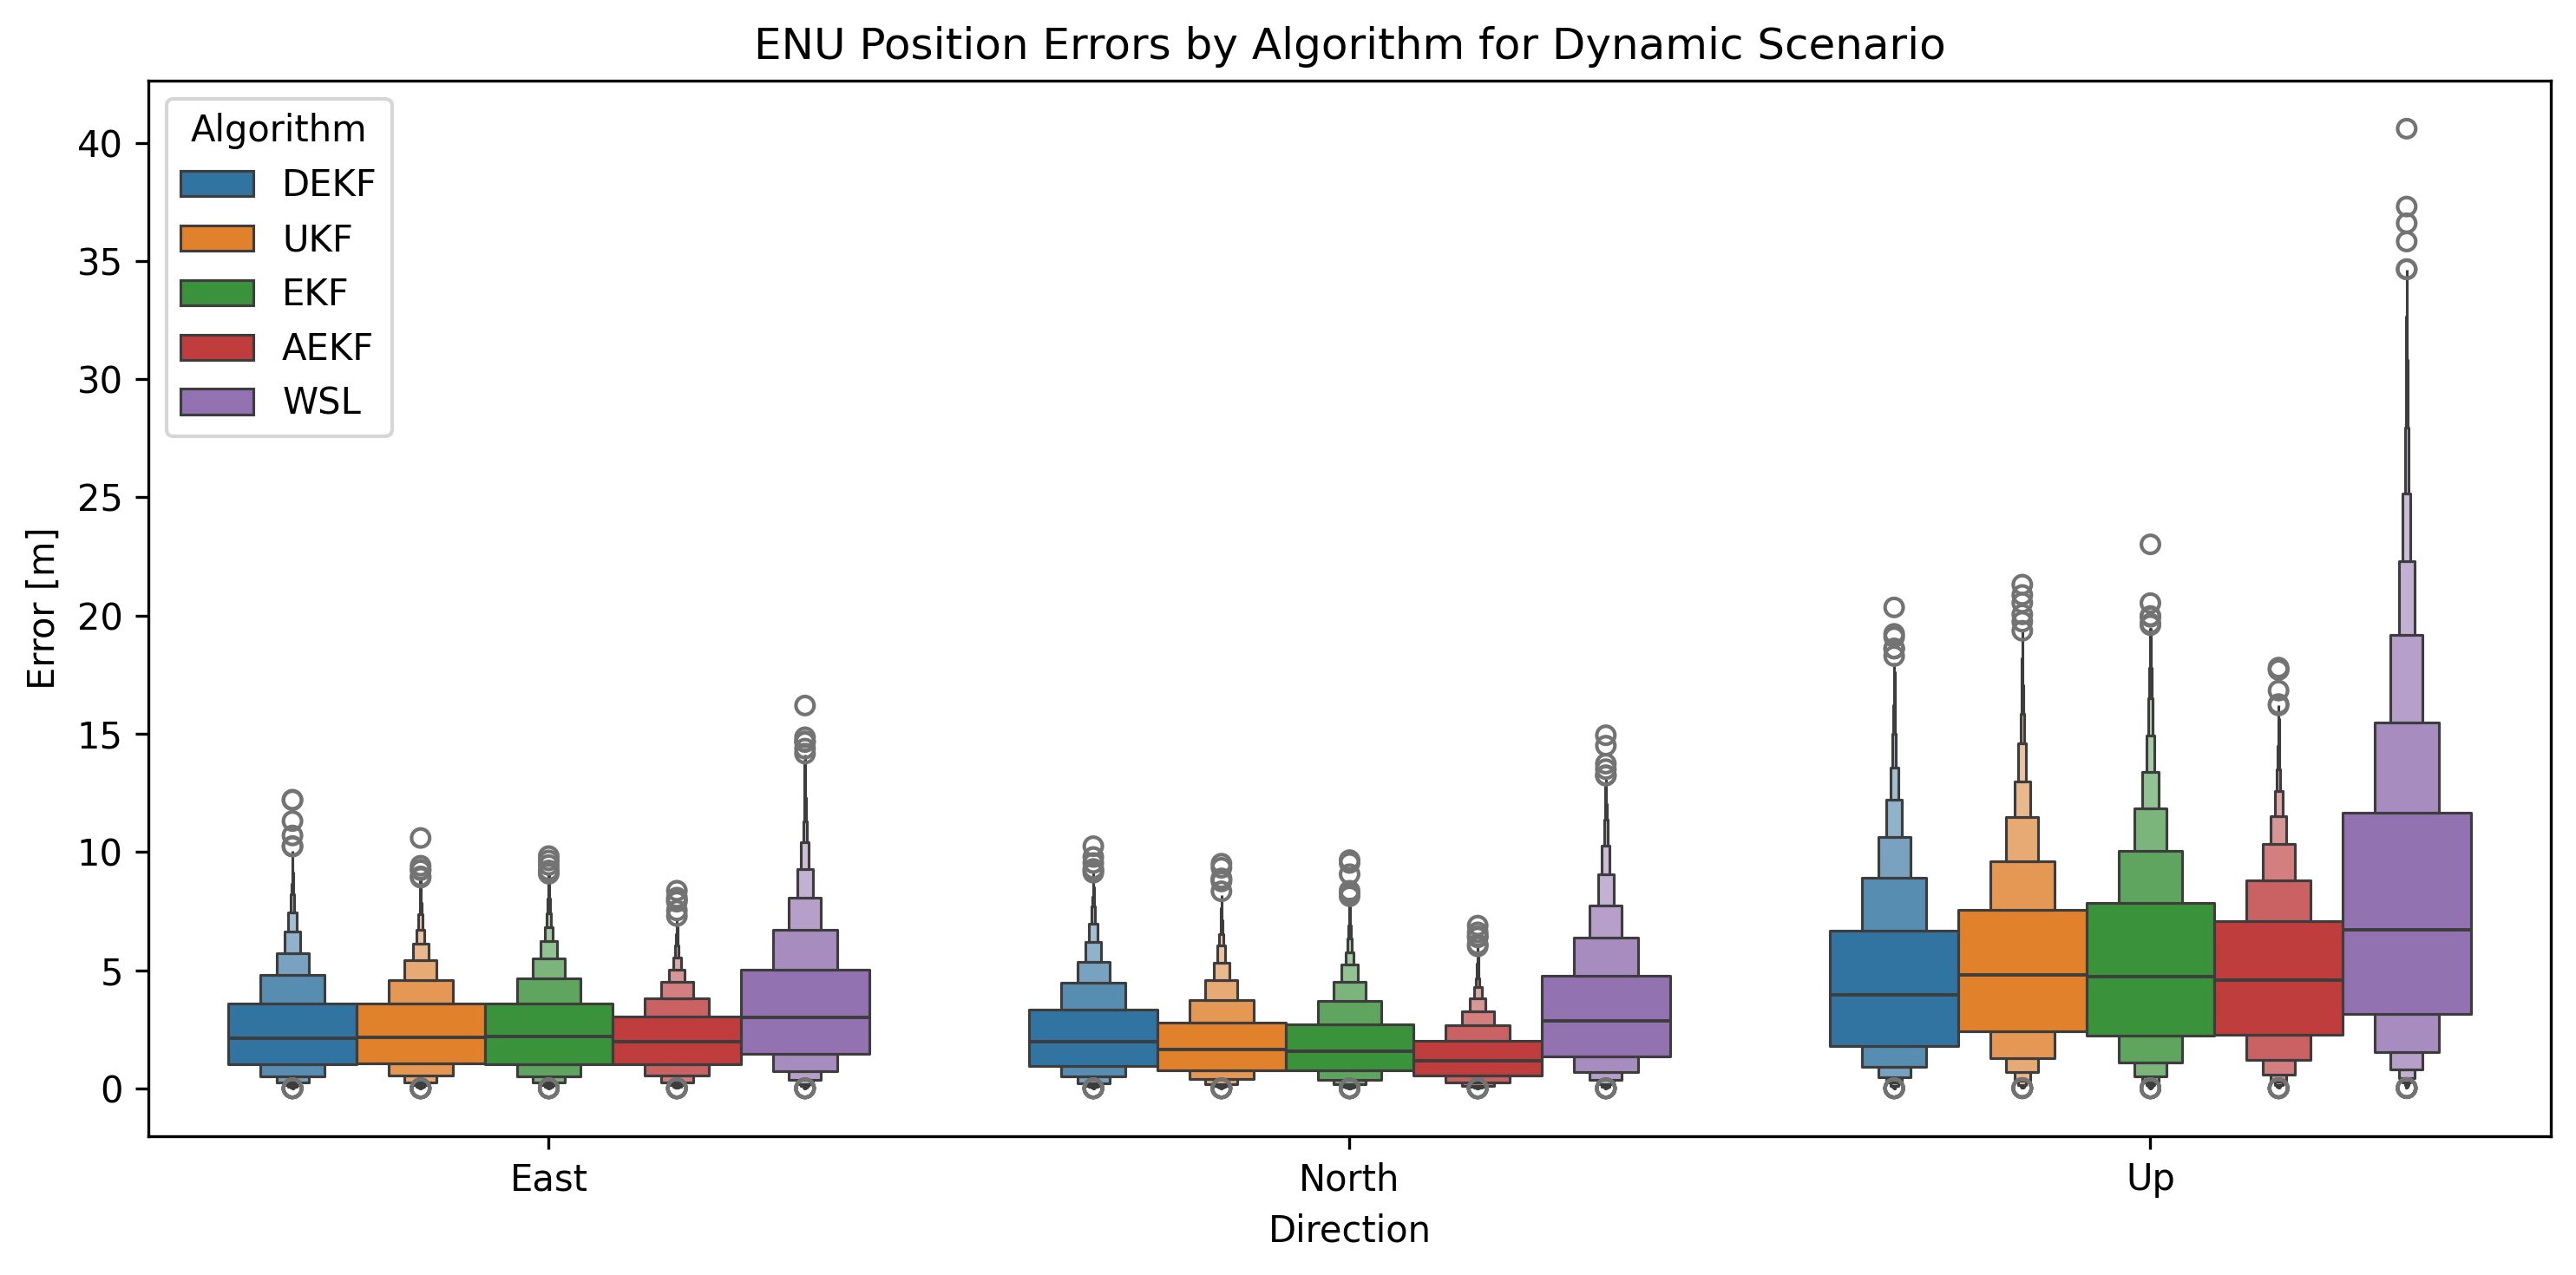

In [23]:
fig, ax = plot_enu_boxen_plot_by_different_algorithm_with_var(enu_by_alogrithm, figsize=(10, 5))


# Add title to the plot
plt.title("ENU Position Errors by Algorithm for Dynamic Scenario")

# Save the figure
fig.savefig("./results/enu_error_along_trajectory.png", dpi=DPI)

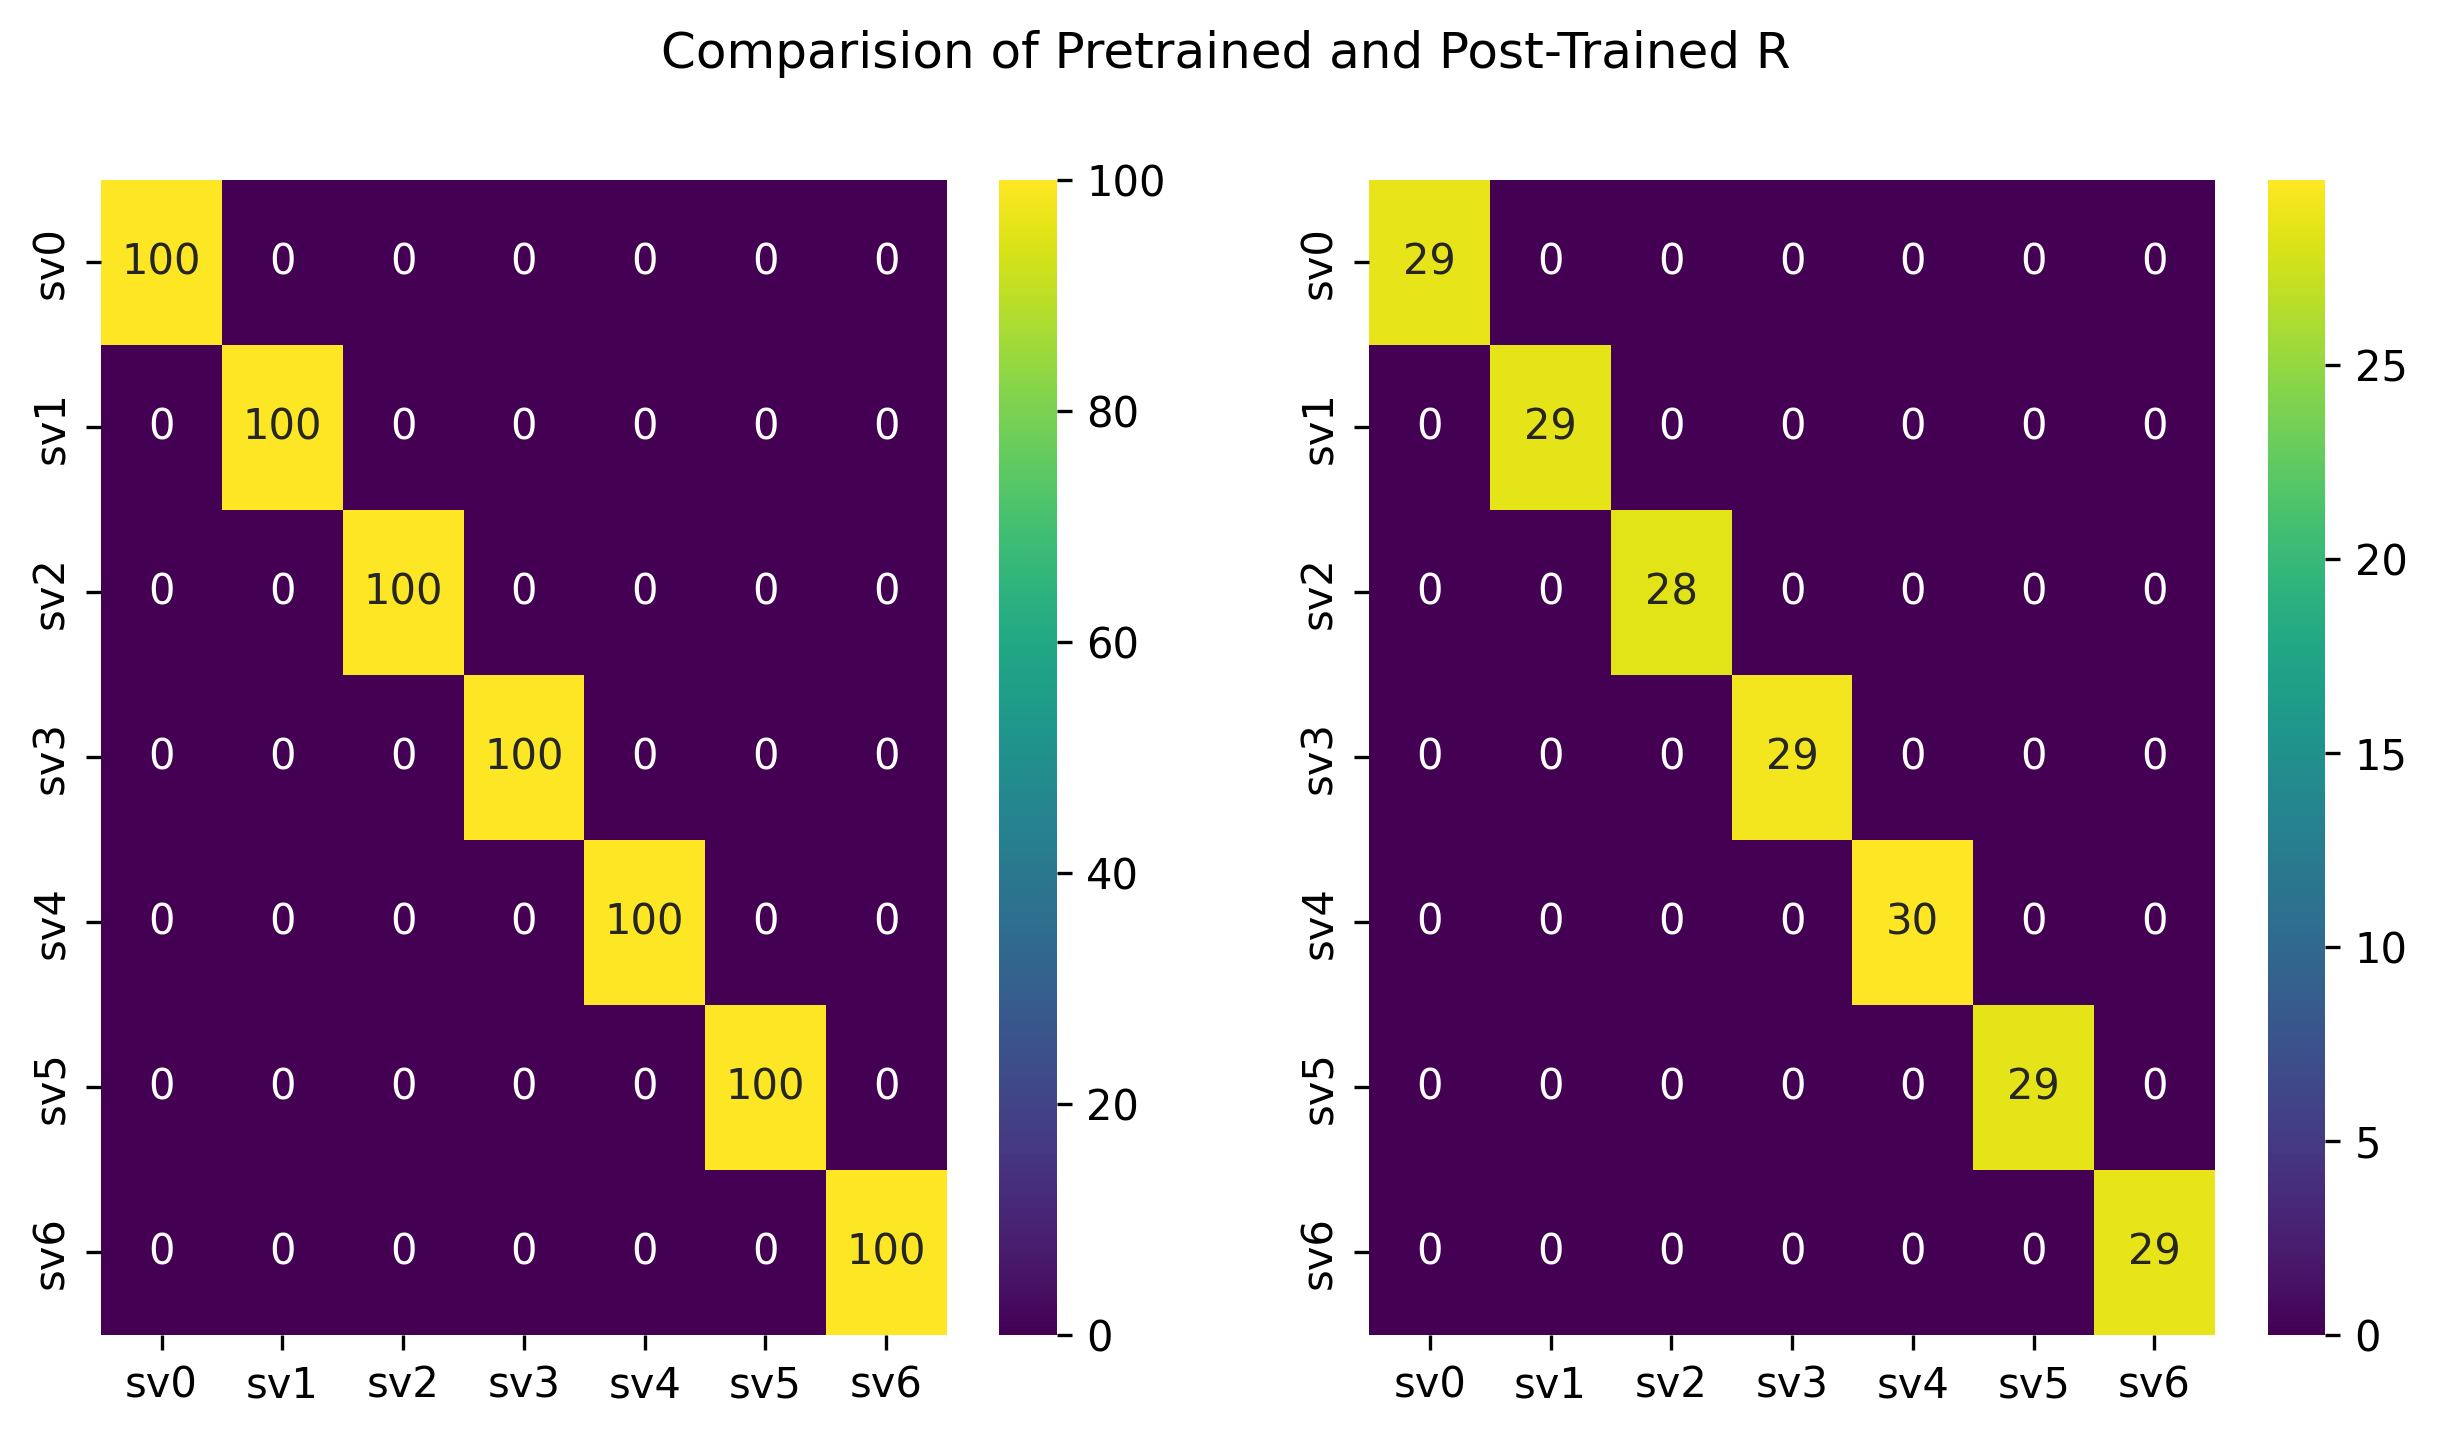

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=300)

SV_I = [f"sv{i}" for i in range(NUM_SV)]

sns.heatmap(
    R.numpy(),
    annot=True,
    fmt=".0f",
    cmap="viridis",
    ax=ax[0],
    yticklabels=SV_I,
    xticklabels=SV_I,
)

sns.heatmap(
    R_module().detach().cpu().numpy(),
    annot=True,
    fmt=".0f",
    cmap="viridis",
    ax=ax[1],
    yticklabels=SV_I,
    xticklabels=SV_I,
)



# Add titlke to the figure
fig.suptitle("Comparision of Pretrained and Post-Trained R")


# Save the figure
fig.savefig("results/R_comparison.png", dpi=DPI, bbox_inches="tight")


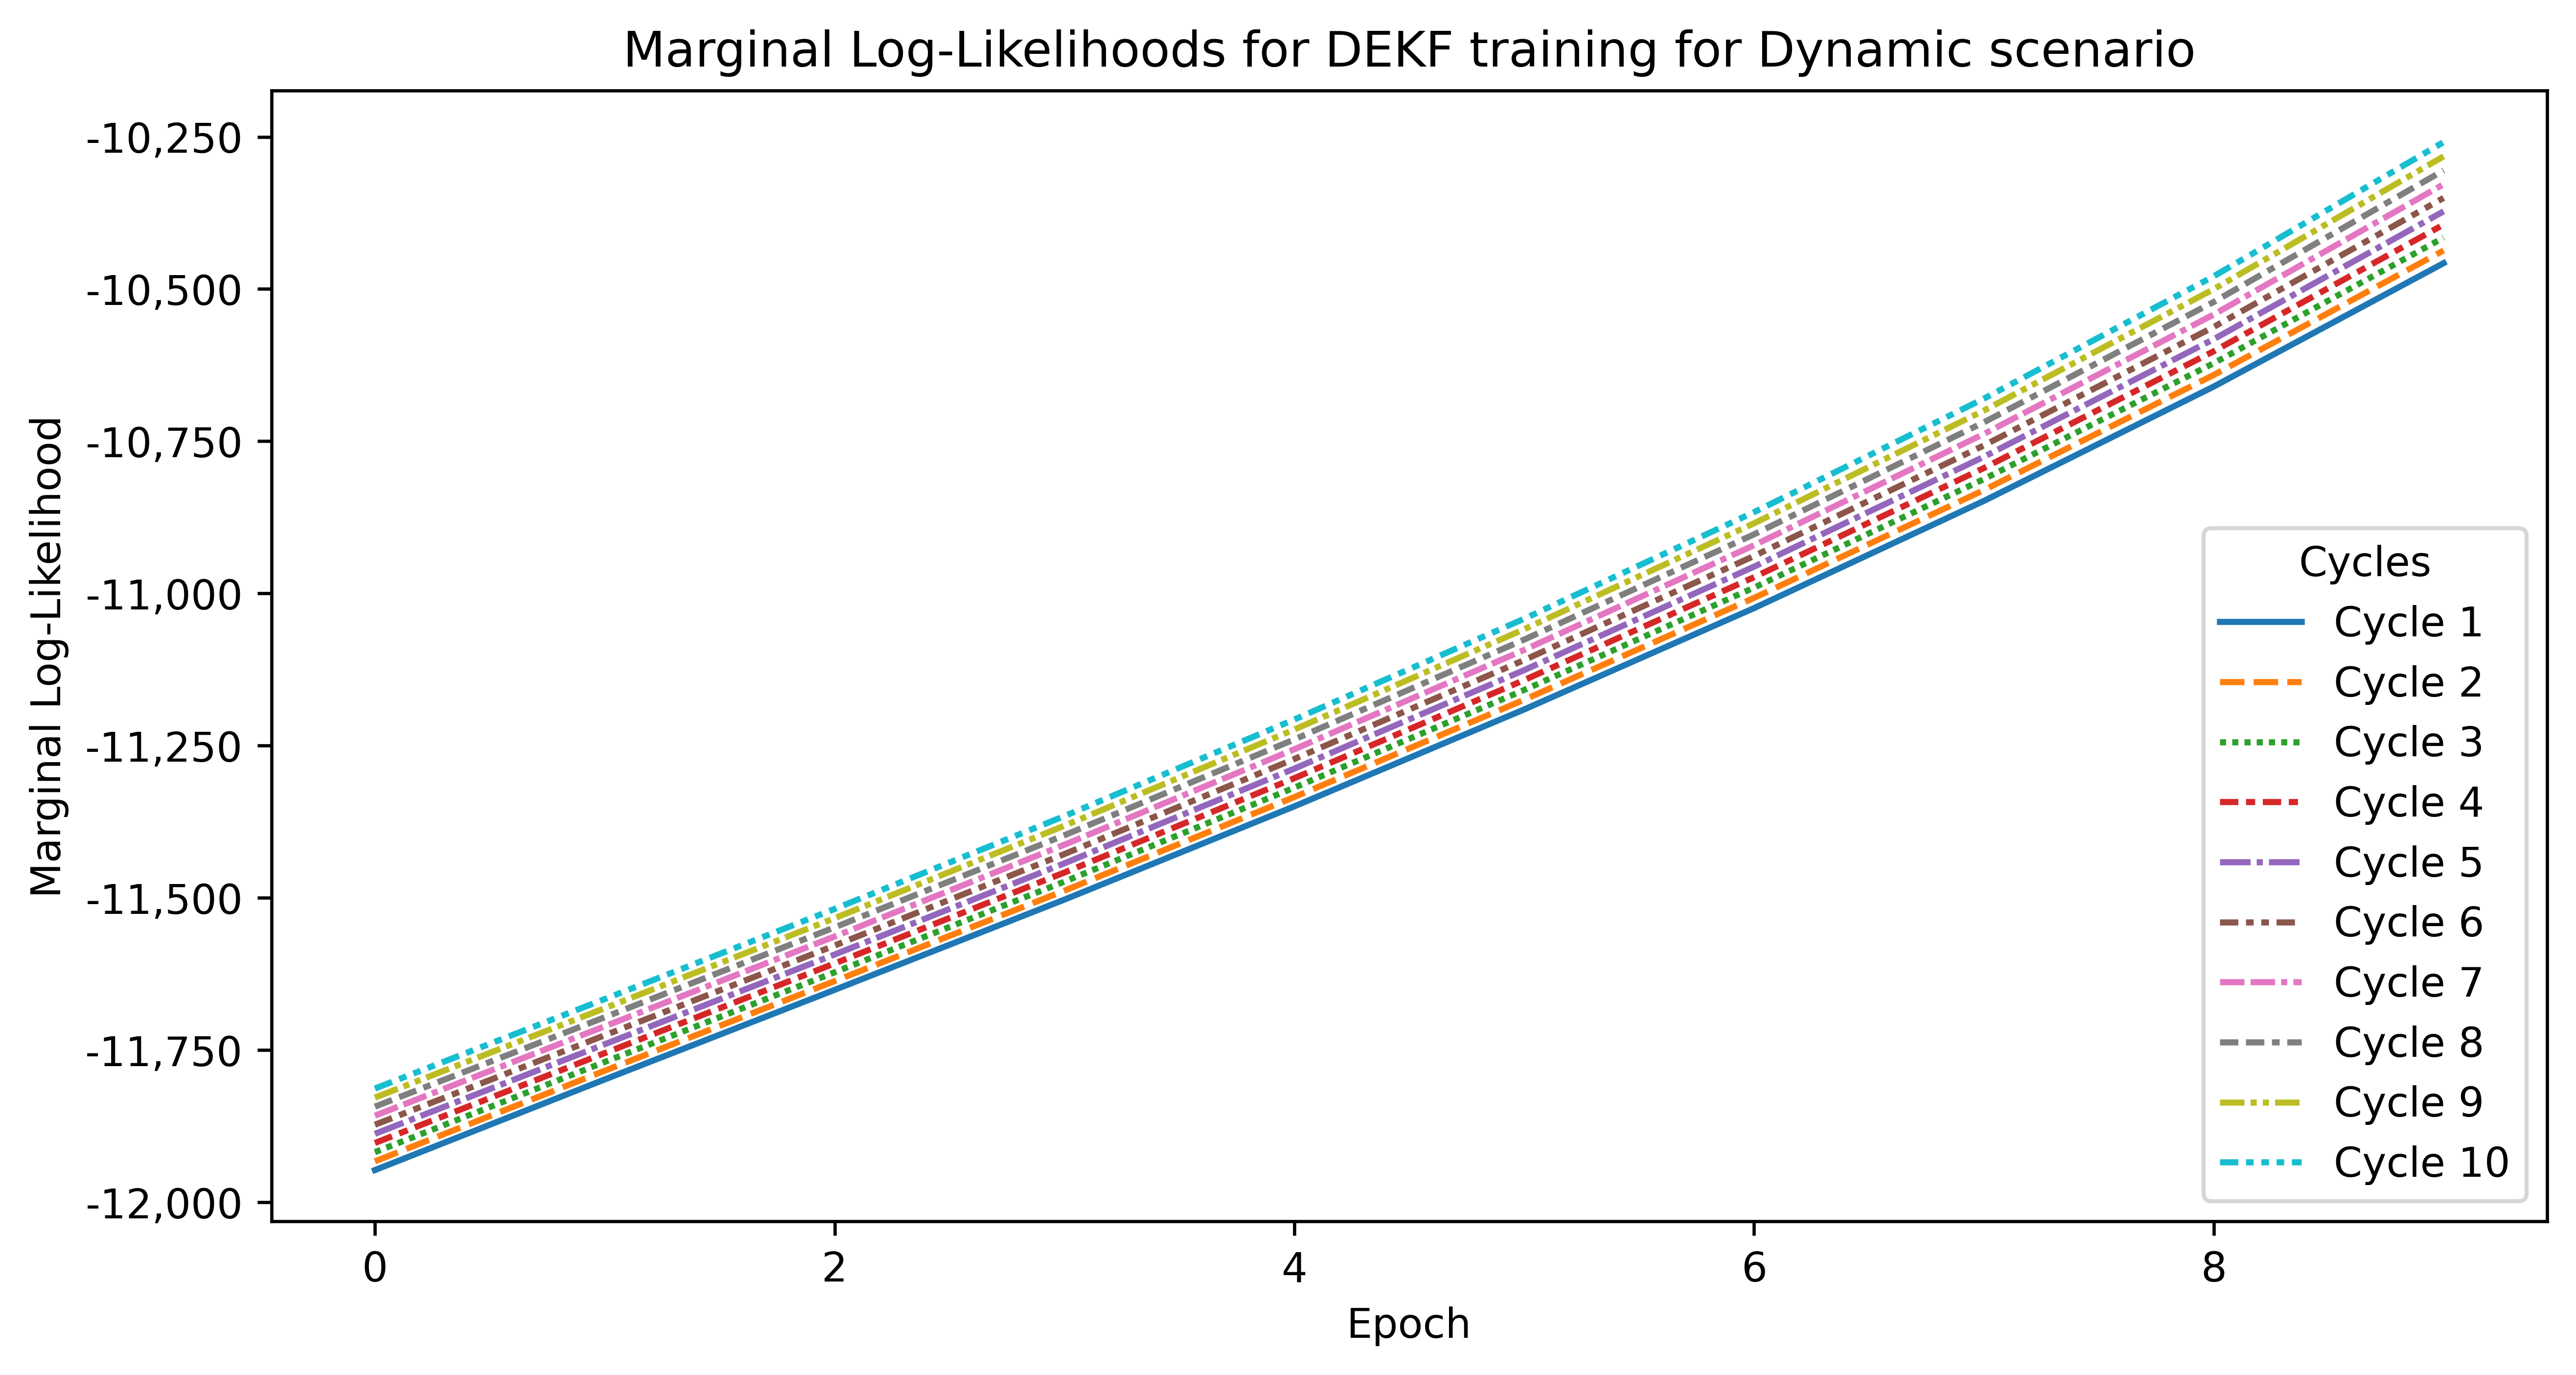

In [25]:
# Plot the log-likelihoods
fig, ax = plt.subplots(figsize=(10, 5), dpi=DPI)

log_likelihoods_df = pd.DataFrame(log_likelihoods["likelihoods"], columns=[f"Cycle {i}" for i in range(1, NUM_CYCLES + 1)])
sns.lineplot(data=log_likelihoods_df, ax=ax)

# Add x and y labels
plt.xlabel("Epoch")
plt.ylabel("Marginal Log-Likelihood")

# Add a title 
plt.title("Marginal Log-Likelihoods for DEKF training for Dynamic scenario")

# Add the legend to right bottom
plt.legend(title="Cycles", loc="lower right")


# Add comma to y-axis
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

# Save the figure
fig.savefig("results/marginal_log_likelihoods.png", dpi=DPI)


In [26]:
# Calculate the means and variances along each direction
error_tabular_map = {
    "DEKF" : {"East" : dekf_results["East"].abs().mean(), "North" : dekf_results["North"].abs().mean(), "Up" : dekf_results["Up"].abs().mean(), "East Std" : dekf_results["East"].abs().std(), "North Std" : dekf_results["North"].abs().std(), "Up Std" : dekf_results["Up"].abs().std()},
    "UKF" : {"East" : ukf_monter_carlo_runs["East"].abs().mean(), "North" : ukf_monter_carlo_runs["North"].abs().mean(), "Up" : ukf_monter_carlo_runs["Up"].abs().mean(), "East Std" : ukf_monter_carlo_runs["East"].abs().std(), "North Std" : ukf_monter_carlo_runs["North"].abs().std(), "Up Std" : ukf_monter_carlo_runs["Up"].abs().std()},
    "EKF" : {"East" : ekf_enu_erros["East"].abs().mean(), "North" : ekf_enu_erros["North"].abs().mean(), "Up" : ekf_enu_erros["Up"].abs().mean(), "East Std" : ekf_enu_erros["East"].abs().std(), "North Std" : ekf_enu_erros["North"].abs().std(), "Up Std" : ekf_enu_erros["Up"].abs().std()},
    "AEKF" : {"East" : aekf_enu_erros["East"].abs().mean(), "North" : aekf_enu_erros["North"].abs().mean(), "Up" : aekf_enu_erros["Up"].abs().mean(), "East Std" : aekf_enu_erros["East"].abs().std(), "North Std" : aekf_enu_erros["North"].abs().std(), "Up Std" : aekf_enu_erros["Up"].abs().std()},
    "WLS" : {"East" : wls_enu_errors["East"].abs().mean(), "North" : wls_enu_errors["North"].abs().mean(), "Up" : wls_enu_errors["Up"].abs().mean(), "East Std" : wls_enu_errors["East"].abs().std(), "North Std" : wls_enu_errors["North"].abs().std(), "Up Std" : wls_enu_errors["Up"].abs().std()},
}

# Save the results as a dataframe

error_tabular = pd.DataFrame(error_tabular_map)

error_tabular.to_csv("results/enu_error_along_trajectory.csv")

## Residual Analysis 

In [27]:
import torch.nn as nn
from ntraingulation.residuals_analysis.errors import MSE, MAD, standerized_residuals, MSSE

def get_residuals(
    measurements: torch.Tensor,
    x0: torch.Tensor,
    P0: torch.Tensor,
    Q: torch.Tensor,
    R: torch.Tensor,
    sv_seq: torch.Tensor,
    device: torch.device,
    dtype: torch.dtype,
    transistion_model: nn.Module,
    measurement_model: nn.Module,
) -> pd.DataFrame:
    """Estimate the position using the Extended Kalman Filter.

    Args:
        measurements: The noisy measurements. (N, DIM_Z)
        x0: The initial state. (DIM_X,)
        P0: The initial covariance. (DIM_X, DIM_X)
        Q: The process noise covariance. (DIM_X, DIM_X)
        R: The measurement noise covariance. (DIM_Z, DIM_Z)
        sv_seq: The sequence of sv's coordinates. (N,3)
        device: The device to use.
        dtype: The datatype to use.

    Args:
        pd.DataFrame: The estimated position in geocentric coordinates.
    """

    # Initialize the filter
    ekf = DiffrentiableKalmanFilter(
        dim_x=8,
        dim_z=measurements.shape[1],
        f=transistion_model,
        h=measurement_model,
    ).to(device=device, dtype=dtype)

    # Take the measurements and other parameters to the device and dtype
    measurements = measurements.to(device=device, dtype=dtype)
    x0 = x0.to(device=device, dtype=dtype)
    P0 = P0.to(device=device, dtype=dtype)
    Q = Q.to(device=device, dtype=dtype)
    R = R.to(device=device, dtype=dtype)
    sv_seq = sv_seq.to(device=device, dtype=dtype)

    # Get the output
    outs = ekf.sequence_filter(
        z_seq=measurements,
        x0=x0,
        P0=P0,
        Q=Q.repeat(measurements.shape[0], 1, 1),
        R=R.repeat(measurements.shape[0], 1, 1),
        h_args=(sv_seq,),
    )
    
    # Now get the residuals
    innovation = outs["innovation"].detach().cpu().numpy()
    covar = outs["innovation_covariance"].detach().cpu().numpy()

    # Standerized residuals
    non_standerized_res = pd.DataFrame(innovation)
    standerized_res = pd.DataFrame(standerized_residuals(innovation, covar))

    # Calculate the MSE and MAD
    mse = MSE(non_standerized_res)
    mad = MAD(non_standerized_res)
    
    return standerized_res, mse, mad

In [28]:
ekf_residuals, ekf_mse, ekf_mad = get_residuals(
    measurements=measurements[:truncation],
    x0=x0,
    P0=P0,
    Q=Q,
    R=R,
    sv_seq=satellite_positions[:truncation],
    device=device,
    dtype=dtype,
    transistion_model=transistion_model,
    measurement_model=observation_model,
)

In [29]:
dekf_residuals, dekf_mse, dekf_mad = get_residuals(
    measurements=measurements[:truncation],
    x0=x0,
    P0=P0,
    Q=Q_module().detach().cpu(),
    R=R_module().detach().cpu(),
    sv_seq=satellite_positions[:truncation],
    device=device,
    dtype=dtype,
    transistion_model=transistion_model,
    measurement_model=observation_model,
)

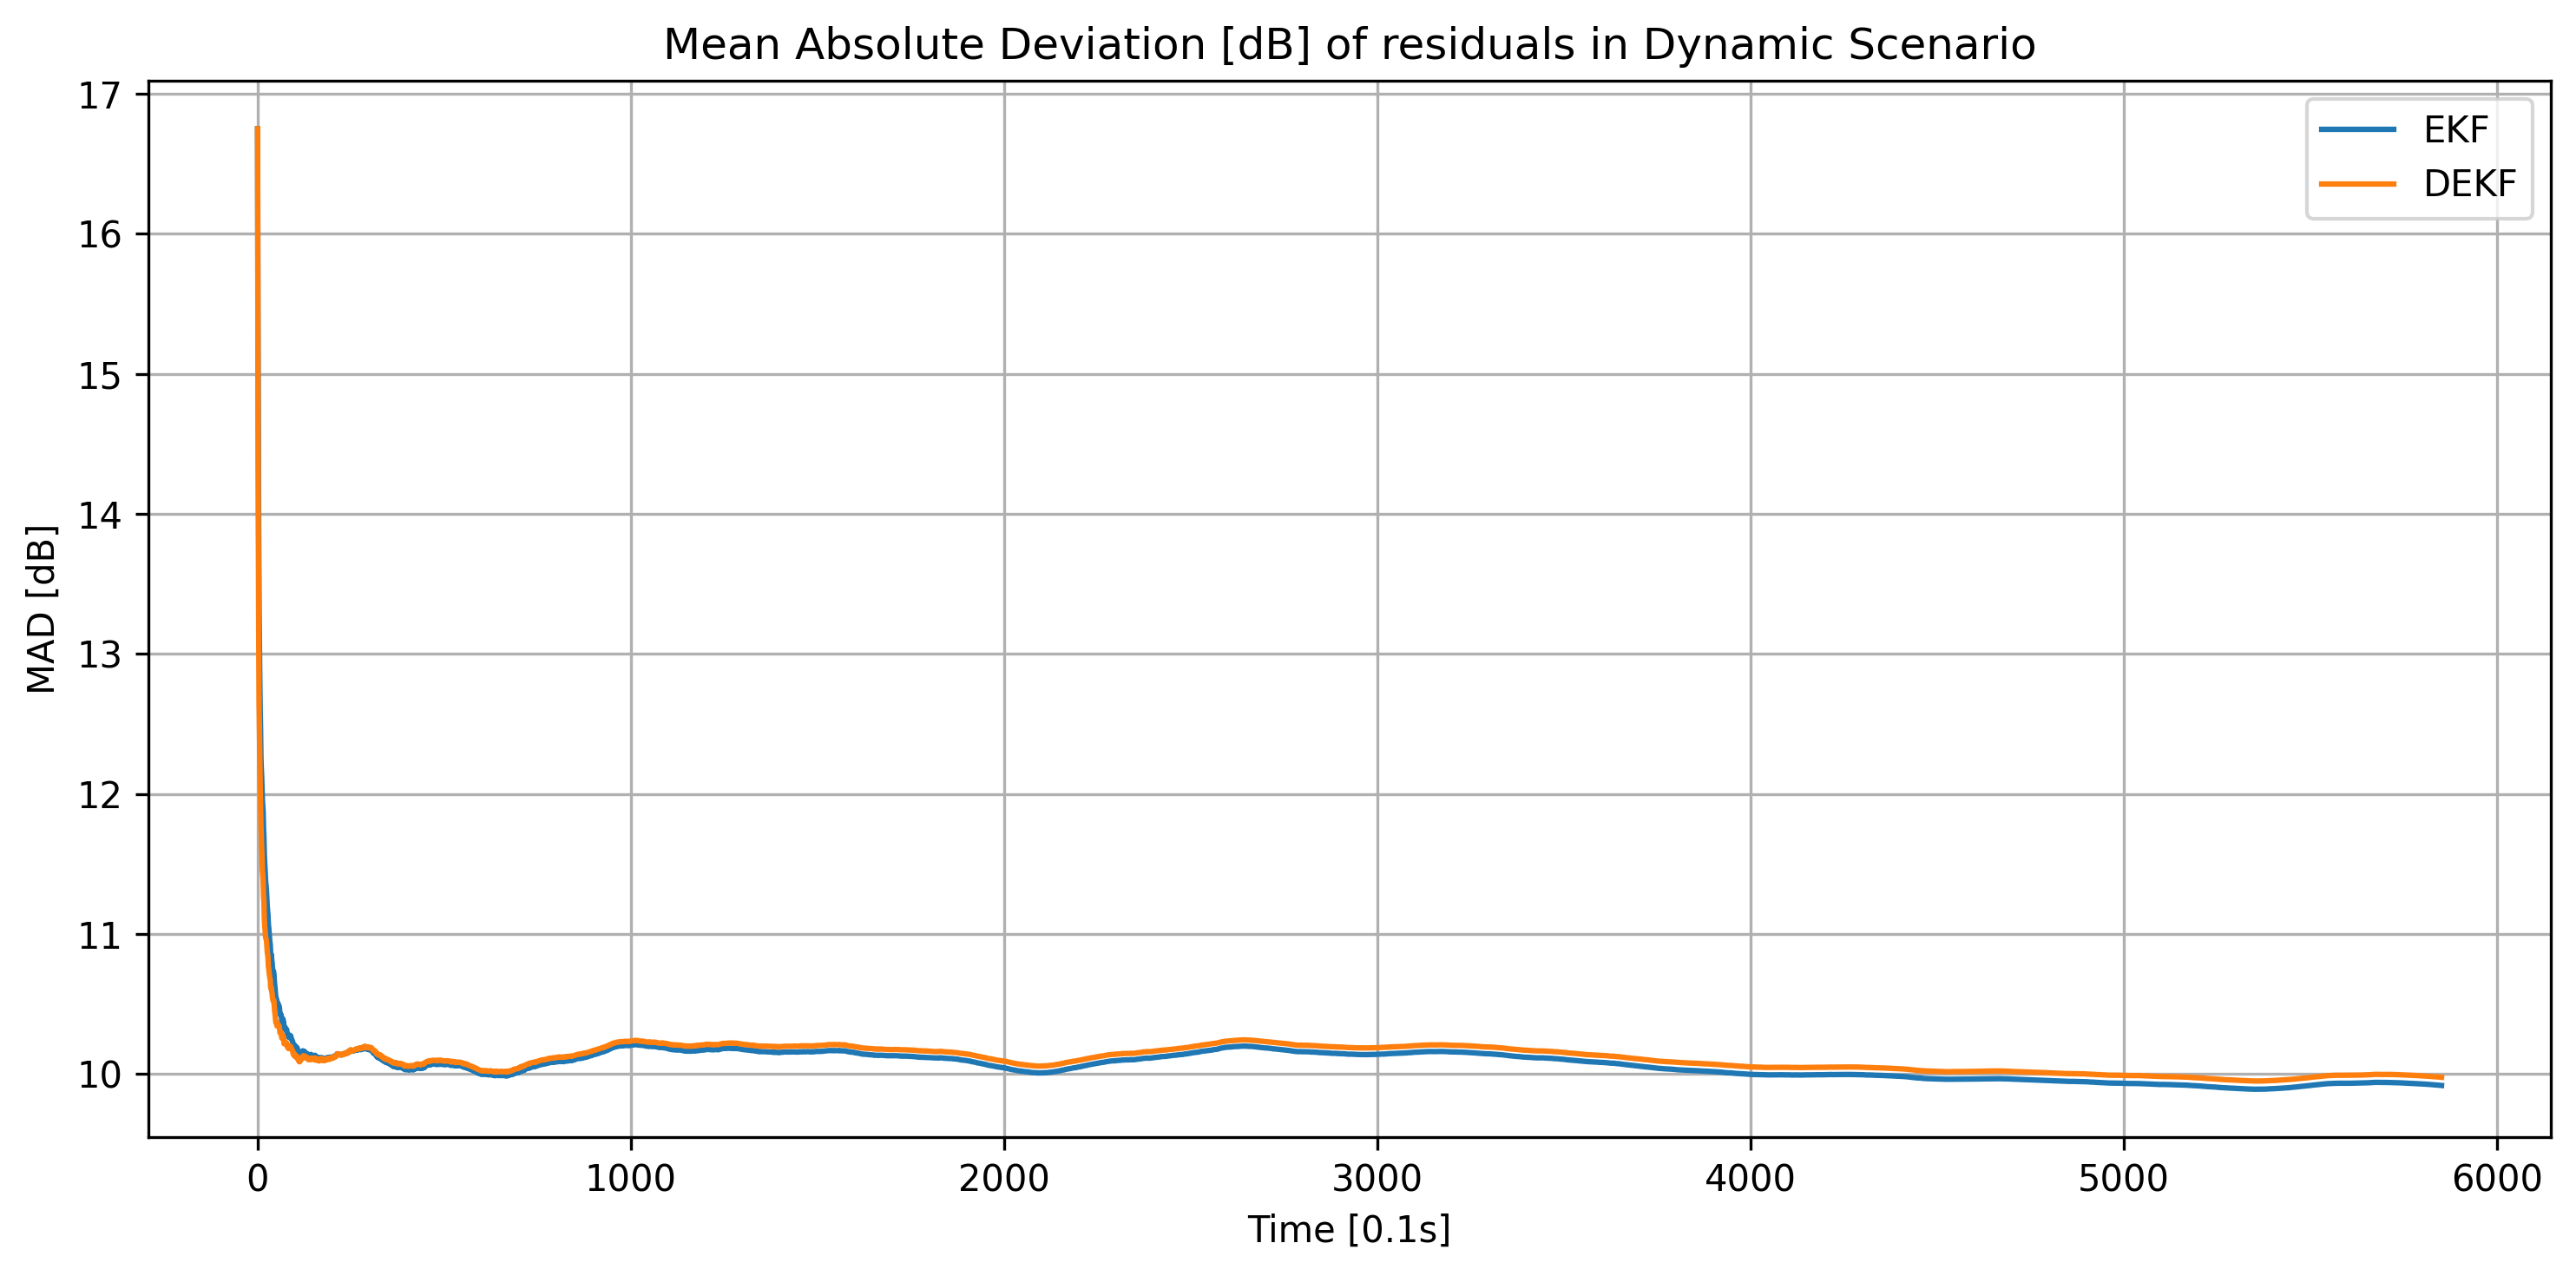

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=300)

def in_DB(x):
    return 10 * np.log10(x)

in_DB(ekf_mad.sum(axis=1)).plot(label="EKF", ax=ax)
in_DB(dekf_mad.sum(axis=1)).plot(label="DEKF", ax=ax)

ax.set_xlabel("Time [0.1s]")
ax.set_ylabel("MAD [dB]")
ax.set_title("Mean Absolute Deviation [dB] of residuals in Dynamic Scenario")
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()


# Save the figure
fig.savefig("results/MAD.png", dpi=DPI)


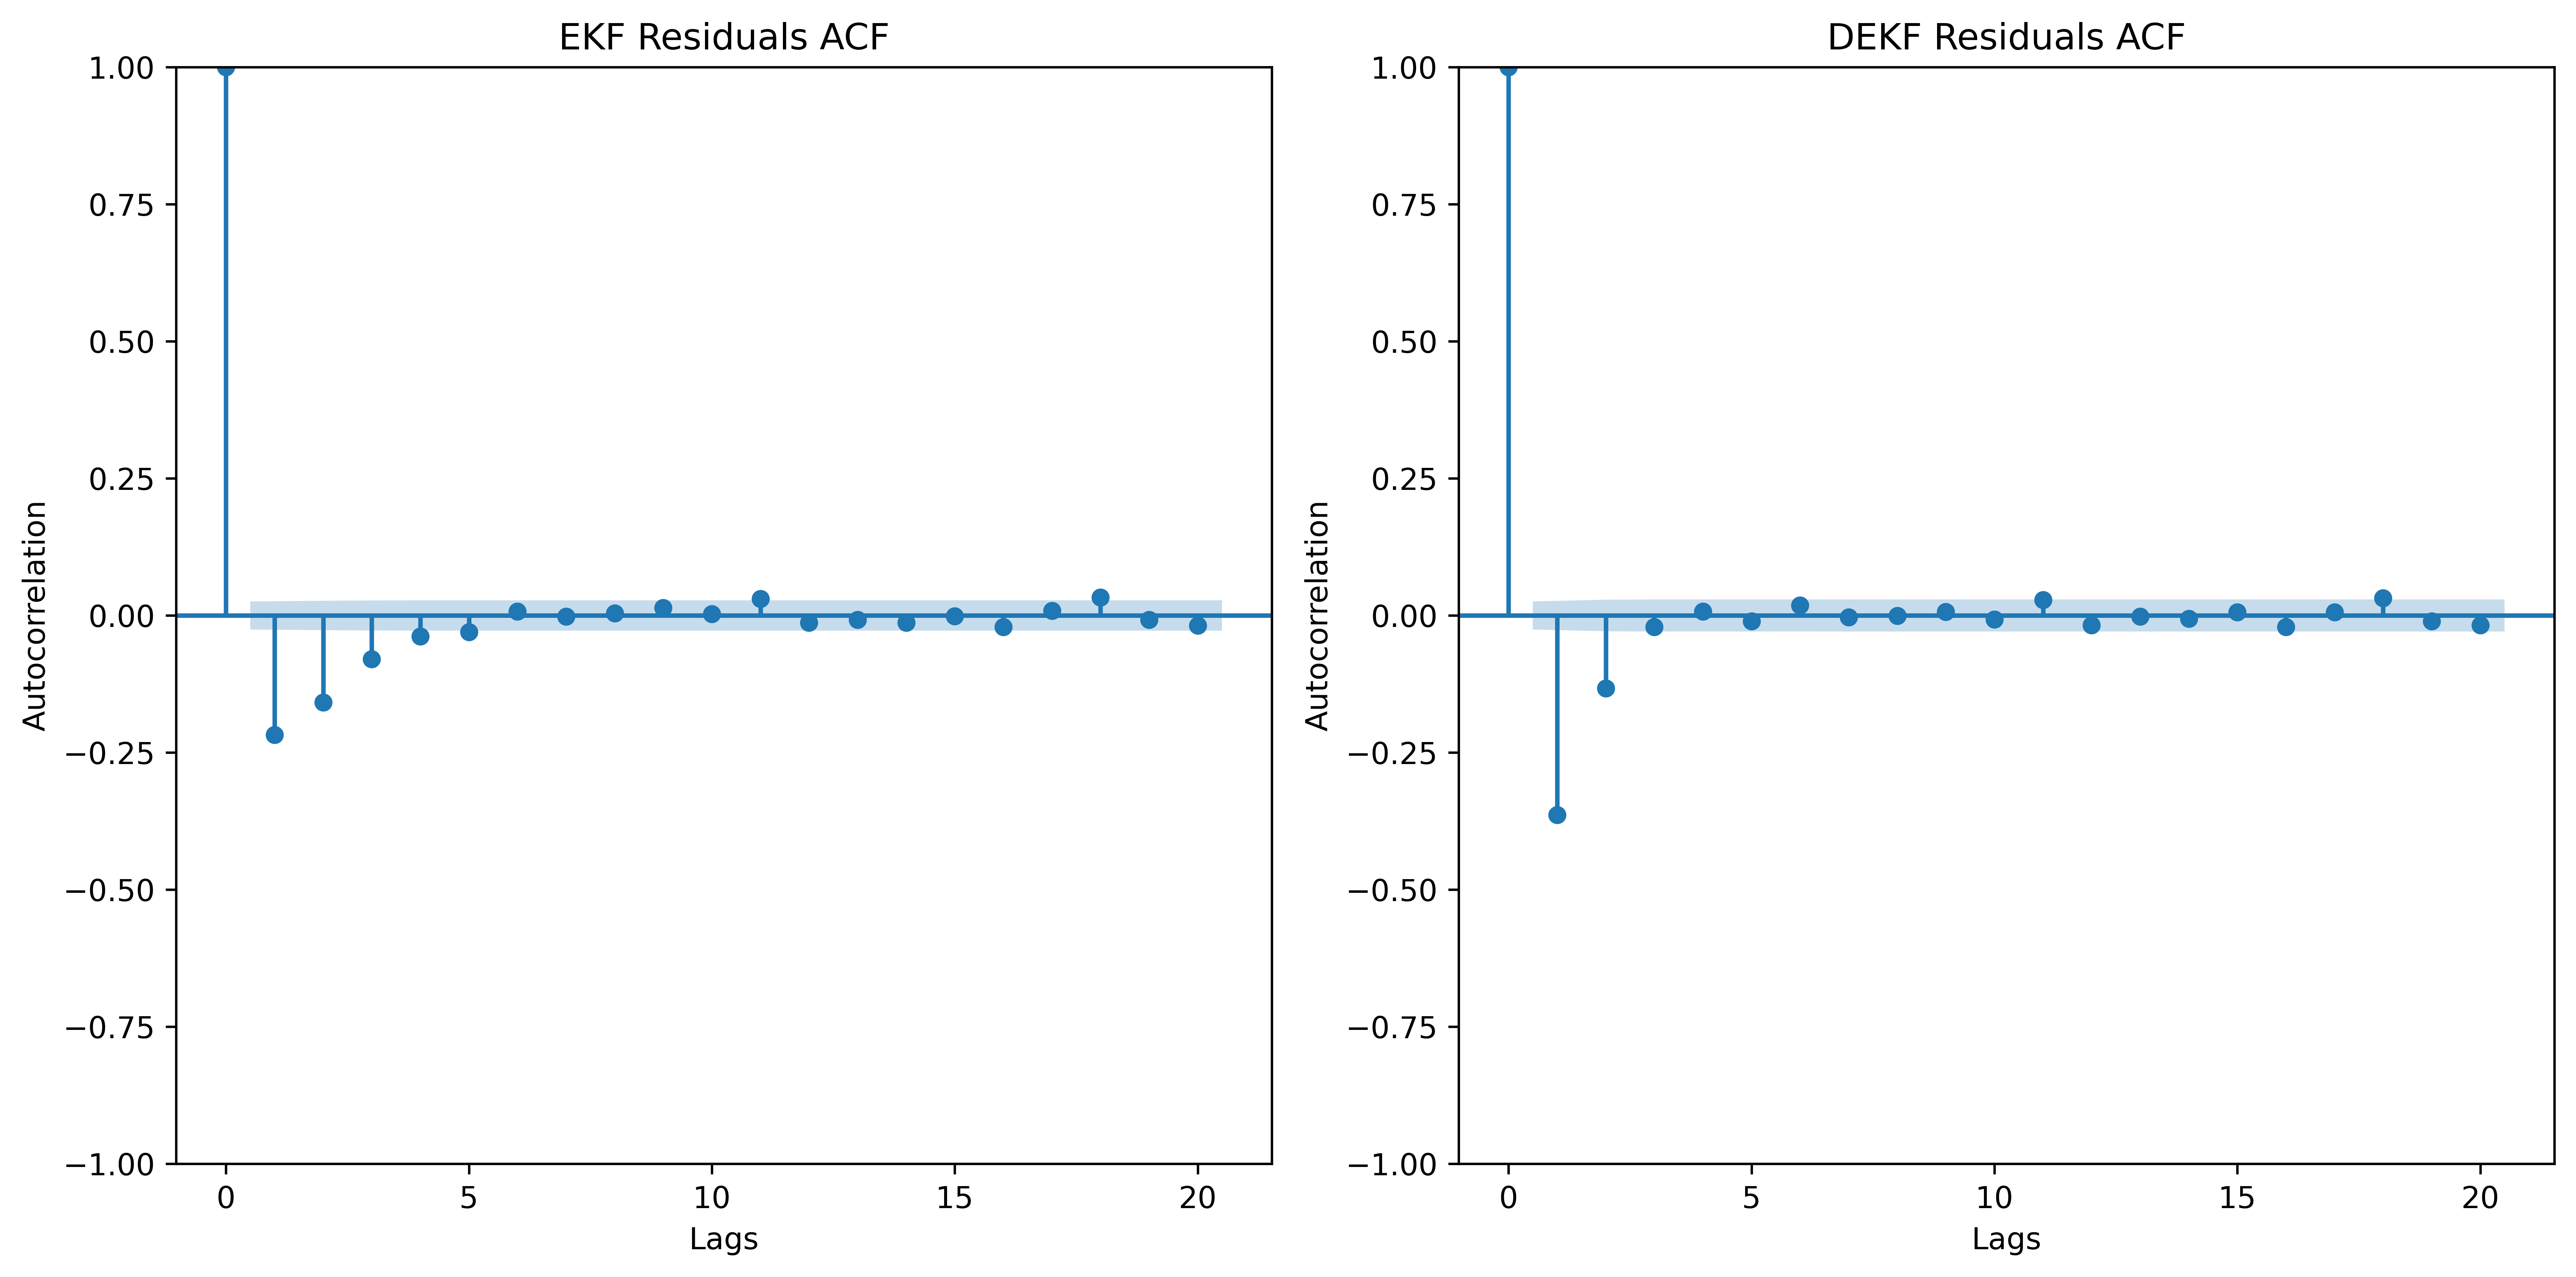

In [31]:
# Caclulate AFC 
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(1, 2, figsize=(12, 6), dpi=DPI)

plot_acf(ekf_residuals.sum(axis=1), ax=ax[0], lags=20, alpha=0.05, title="EKF Residuals ACF")
plot_acf(dekf_residuals.sum(axis=1), ax=ax[1], lags=20, alpha=0.05, title="DEKF Residuals ACF")

ax[0].set_xlabel("Lags")
ax[0].set_ylabel("Autocorrelation")
ax[1].set_xlabel("Lags")
ax[1].set_ylabel("Autocorrelation")

plt.tight_layout()
fig.savefig("results/ACF.png", dpi=DPI, bbox_inches="tight")
plt.show()